# 3' Rapid Amplification of cDNA Ends (RACE) of human telomerase (hTR) gene Analysis
    author: Morgan R Weichert
    email: morgan@baumannlab.org

###### Input dataset 

| Data         | Location                                       | Type   | Read Length | Lanes|
|-------------------|------------------------------------------------|--------|-------------|----|
| Seqence directory | /path/to/raw/data/| Paried |         RapidSeq-250 |2|

> The amplicons contain (from 5' to 3'):
- 10 nt Molecular Barcode: NNNNNNNNNN
    - barcode is for removing PCR duplicates/bias
- hTR-specific primer: CAGGAAGAGGAACGGAGCGAGT
- hTR insert sequence (variable ending position): CCCCGCGCGCGGCGCGATTCCCTGAGCTGTGGGACGTGCACCCAGGACTCGGCTCACACATGC
- ntna (non-templated nucleotide addition) sequence: variable length & sequence
    - ntna sequence includes polyA tails or any other sequence that is not the reference hTR sequence
- linker (adaptor) sequence: TTTAACCGCGAATTCCAG
    - the linker seq will be variable length depending on how long the hTR sequence is and how long the ntna sequence is
- AC-index
- P7 Adapter: ATCTCGTATGCCGTCTTCTGCTTG

###### import python packages

In [3]:
import os
import re
import gzip
import glob
import regex
import commands
import subprocess
import numpy as np
import pandas as pd
from Bio import Seq
from Bio import SeqIO
from collections import Counter

## raw reads to analysis ready reads

### create symbolic links to raw data
this saves space by pointing to the raw fastq files so that I don't need to copy them into my own directory

In [ ]:
# %load /home/msr/general_scripts/create_symlinks_to_data.R
#!/n/apps/CentOS7/bin/Rscript

#################################################################################################
# R script for matching fastq names from machine (s_lane_read_index.fastq) 
# to the sample name given in the sample report (control_1) 
# and creates raw_data directory containing symbolic links to the renamed fastq files.
# The symbolic linked fastq files have renamed format samplename_lane_read.fastq

# This script is to be ran on the command line giving a directory to the raw data
# Example: $ create_symlinks_to_data.R /path/to/raw/data/
# This script also assumes there is a SampleReport.csv file in the given directory
# containg a column 'Output' and a column 'SampleNames'
#################################################################################################

args = commandArgs(trailingOnly = TRUE) # script expects arguments trailing
fc.dir <- args[1] # the first argument is the flowcell directory

################ parse sample report ############################################################
molng <- unlist(strsplit(fc.dir, '/'))[6] # this is the sequenced order ID

fqs <- list.files(fc.dir, "[ACGT].+\\.fastq\\.gz", full = TRUE) # list of the fastq files
#print(length(fqs)) # check number of samples matches

report <- read.csv(list.files(fc.dir, "Report\\.csv", full = TRUE)) # read in the SampleReport.csv
# subset the sample report to ony this sqeuencing order
# this is required because sometime multipe separate orders are sequenced together
report <- subset(report, report$Order == molng) 
#print(unique(report$SampleName)) # if you want to check the sample names

# match the sample name (control_1) to the machine name (s_lane_read_index)
samples <- as.character(report$SampleName[match(basename(fqs), report$Output)]) 
#print(unique(samples)) # check matching correctly

lanes <- as.character(report$Lane[match(basename(fqs), report$Output)]) # grab the corresponding lane
read <- as.character(report$Read[match(basename(fqs), report$Output)]) # grab the corresponding read 
                                                                      # (1 fw read, 2 rev read)
#####################################################################################################

# create file paths with new name format sample_lane_read
links <- file.path("raw_data",
                   paste0(paste(samples,lanes,read,sep="_"),".fastq.gz"))
# print(links) # check this works

####### create raw_data direcotry with create symlinks ################
dir.create("raw_data",FALSE,TRUE) # give FALSE if file alread exists    
file.symlink(fqs,links)
warnings()
#####################################################################################################


In [ ]:
%%bash 

create_symlinks_to_data.R /path/to/raw/data/

### Raw Read Counts per Sample

In [ ]:
# %load /home/msr/general_scripts/count_reads_per_sample.py
#!/home/msr/bin/anaconda/bin/python

"""
python script for counting reads in fastq file
run on command line and specify (1) directory of fastq files and (2) output tsv file name
assumes sample naming convention of samplename_lane_read.fastq.gz
Example: 
$ count_number_single_reads_per_sample.py -indir ./raw_data/ -outfile raw_read_counts_per_sample.tsv
"""

import os
import re
import argparse
import commands
import pandas as pd

################################ set up user input ##############################################
parser = argparse.ArgumentParser(
    description='Count number of reads for each file in dir')
# define arguments
parser.add_argument('-indir', type=str, required=True,
                    help='input directory of gzipped fastq files')
parser.add_argument('-outfile', type=str, required=True,
                    help='path to tsv output file')
args = parser.parse_args()
#################################################################################################

df = pd.DataFrame()  # initialize dataframe

#################################################################################################
for i in os.listdir(args.indir): # for each file (i) in the given directory
    
    # here samples are named samplename_lane_read.fastq.gz
    sample_name = re.split(r'_([0-9])_([0-9]).fastq', i)[0]  # grap sample name
    read = re.split('_', re.split(r'.fastq', i)[0])[-1]  # grab read number (1=fw, 2=rev)
    lane = re.split('_', re.split(r'.fastq', i)[0])[-2]  # grab lane number

    # unix to count num lines in file
    lane_lines = commands.getoutput('zcat ' + args.indir + i + '| wc -l')
    # divide by 4 for to get number of reads for fastq files
    lane_reads = int(lane_lines) / 4.0

    # store in dataframe
    df = df.append({'lane_read': str('lane_' + lane + '_read_' + read),
                    'read_count': lane_reads,
                    'sample': sample_name},
                    ignore_index = True)

#################################################################################################

# reorganize dataframe
df = df.pivot_table(values  = 'read_count',
                    index   = ["sample"],
                    columns = ['lane_read'])

if len(df.columns) > 1: # if the sample was run on more than one lane compute a total
    df["total_reads"] = df.sum(axis=1)
# print df

# write dataframe to csv
df.to_csv(args.outfile,
          sep='\t',
          header=True,
          index=True,
          index_label=['sample'])


In [ ]:
%%bash

count_reads_per_sample.py -indir ./raw_data/ -outfile raw_read_counts_per_sample.tsv

In [31]:
%%bash

/home/msr/general_scripts/count_reads_per_sample.py \
-indir /home/msr/code_examples/hTR_3prime_RACE_analysis_files/raw_data_subset_25_seqs/ \
-outfile /home/msr/code_examples/hTR_3prime_RACE_analysis_files/raw_data_subset_25_seqs/raw_read_counts_per_sample.tsv

In [32]:
# view raw read counts computed above
pd.read_csv('/home/msr/code_examples/hTR_3prime_RACE_analysis_files/raw_data_subset_25_seqs/raw_read_counts_per_sample.tsv', 
            sep = '\t')

sample  lane_1_read_1
0     329_PARNOE_25seqs           25.0
1  HeLa_totalRNA_25seqs           25.0

### Filter reads without hTR sequence
this is required because this library was spiked into another sequencing library to increase complexity

In [33]:
%%bash
mkdir -p /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data
mkdir -p /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/seq_filtered

In [34]:
############### split hTR sequence into 20-mers as targets for requrired read matching #############################

# this is the reference hTR sequence from postion 366 to 451, the mature form of hTR
hTR_mature = "CAGGAAGAGGAACGGAGCGAGTCCCCGCGCGCGGCGCGATTCCCTGAGCTGTGGGACGTGCACCCAGGACTCGGCTCACACATGC"

# this is the reference sequence for hTR following position 451, sequence for hTR from position 452 to 641
# any sequence past position 451 is called a precursor form of hTR 
precursor = "AGTTCGCTTTCCTGTTGGTGGGGGGAACGCCGATCGTGCGCATCCGTCACCCCTCGCCGGCAATGGGGGCTTGTGAACCCCC\
AAACCTGACTGACTGGGCCAGTGTGCTGCAAATTGGCAGGAGACGTGAAGGCACCTCCAAAGTCGGCCAAAATGAATGGGCAGTGAGCCGGGGTTGCCTGGAGCCGTT"

coord_start = 451 + len(precursor) # the startding coordinate is the most 3' coordinate, here 641

hTR_seq = hTR_mature + precursor # combine mature and precursor form into one sequence
hTR_seq_rc = Seq.reverse_complement(hTR_seq) # also reverse compliment

def hTR_targets(htr_seq):
    targets = [] # initialize array
    c = len(htr_seq) # length of given sequence
    for i in range(c-19): # index across sequence, for as long as the sequence-19 
                          # (subtracting 19 bc doing this for bins of 20nt kmers) 
        if i == 0: # if this is the begining of the sequence
            fragment = htr_seq[-20:] # grab the last 20 nt of the sequence
            targets.append(fragment) # add it to our targest array
        else:
            fragment = htr_seq[-(i + 20):-i] # move across the sequence in 1 nt windowns, starting from the end 
            targets.append(fragment) # append current 20nt window to the array
        #print fragment
    return targets

targets = hTR_targets(hTR_seq)
targets_rc = hTR_targets(hTR_seq_rc)
print targets

['CGGGGTTGCCTGGAGCCGTT', 'CCGGGGTTGCCTGGAGCCGT', 'GCCGGGGTTGCCTGGAGCCG', 'AGCCGGGGTTGCCTGGAGCC', 'GAGCCGGGGTTGCCTGGAGC', 'TGAGCCGGGGTTGCCTGGAG', 'GTGAGCCGGGGTTGCCTGGA', 'AGTGAGCCGGGGTTGCCTGG', 'CAGTGAGCCGGGGTTGCCTG', 'GCAGTGAGCCGGGGTTGCCT', 'GGCAGTGAGCCGGGGTTGCC', 'GGGCAGTGAGCCGGGGTTGC', 'TGGGCAGTGAGCCGGGGTTG', 'ATGGGCAGTGAGCCGGGGTT', 'AATGGGCAGTGAGCCGGGGT', 'GAATGGGCAGTGAGCCGGGG', 'TGAATGGGCAGTGAGCCGGG', 'ATGAATGGGCAGTGAGCCGG', 'AATGAATGGGCAGTGAGCCG', 'AAATGAATGGGCAGTGAGCC', 'AAAATGAATGGGCAGTGAGC', 'CAAAATGAATGGGCAGTGAG', 'CCAAAATGAATGGGCAGTGA', 'GCCAAAATGAATGGGCAGTG', 'GGCCAAAATGAATGGGCAGT', 'CGGCCAAAATGAATGGGCAG', 'TCGGCCAAAATGAATGGGCA', 'GTCGGCCAAAATGAATGGGC', 'AGTCGGCCAAAATGAATGGG', 'AAGTCGGCCAAAATGAATGG', 'AAAGTCGGCCAAAATGAATG', 'CAAAGTCGGCCAAAATGAAT', 'CCAAAGTCGGCCAAAATGAA', 'TCCAAAGTCGGCCAAAATGA', 'CTCCAAAGTCGGCCAAAATG', 'CCTCCAAAGTCGGCCAAAAT', 'ACCTCCAAAGTCGGCCAAAA', 'CACCTCCAAAGTCGGCCAAA', 'GCACCTCCAAAGTCGGCCAA', 'GGCACCTCCAAAGTCGGCCA', 'AGGCACCTCCAAAGTCGGCC', 'AAGGCACCTCCAAA

In [37]:
############### Require read to contain: #############################################################
############### at least 20nt exact match to hTR sequence (or rev comp) ##############################
############### exact match 10nt to linker sequence ##################################################

linker = "TTTAACCGCG"
linker_rc = "CTGGAATTCG"

def my_filter(records):
    for rec in records:
        match_linker = regex.search(linker, str(rec.seq)) # seach for linker sequence in read
        match_linker_rc = regex.search(linker_rc, str(rec.seq)) # same for rev comp
        match_hTR = any(i in str(rec.seq) for i in targets) # see if any 20 nt region of hTR sequence matches read
        match_hTR_rc = any(i in str(rec.seq) for i in targets_rc) # same for rev comp
        
        # if linker match is found and hTR match found keep the read
        if (match_hTR and match_linker) or (match_hTR_rc and match_linker_rc):
            yield rec

path = "/home/msr/code_examples/hTR_3prime_RACE_analysis_files/raw_data_subset_25_seqs/"
for sample in os.listdir(path):
    samp = (os.path.splitext(sample)[0]).split(".fastq.gz")[0] # grab sample name
    fastq_parser = SeqIO.parse(gzip.open(path+sample), "fastq") # use SeqIO to parse fastq file
    SeqIO.write(my_filter(fastq_parser), # write fastq files that pass my_filer function
                "/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/seq_filtered/"+samp,
                "fastq")

In [39]:
%%bash
# gzip the fastq files we just created
for i in /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/seq_filtered/*.fastq;
do
    pigz -p 8 $i
done

#### check number of reads per sample after filtering

In [ ]:
%%bash

# using same script as explained in 'Raw Read Counts per Sample' section
count_reads_per_sample.py -indir ./processed_data/seq_filtered/ -outfile filtered_read_counts_per_sample.tsv

In [42]:
%%bash
/home/msr/general_scripts/count_reads_per_sample.py \
-indir /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/seq_filtered/ \
-outfile /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/filtered_read_counts_per_sample.tsv

In [43]:
# view results
pd.read_csv('/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/filtered_read_counts_per_sample.tsv',
            sep = '\t')

sample  lane_1_read_1
0     329_PARNOE_25seqs           25.0
1  HeLa_totalRNA_25seqs           25.0

### Combine all Fw (& all Rev Reads) per Sample - If sequenced on multiple lanes

In [ ]:
%%bash

mkdir -p processed_data/seq_filtered_cat

In [ ]:
def combine_lanes(path, outpath):
    """ this function take all the fastq files in a directory, 
    and combines fw & rev reads based on the sample naming convention: sample_lane_read.fastq.gz"""
    
    samples=[] # initialize array
    for sample in os.listdir(path): # for each fastq file in directory
        if re.match('.*\.fastq.gz', sample): # make sure it is a fastq file
            samples.append(re.split('_[1,2]_[1,2].fastq.gz', sample)[0]) # grab sample name and add to array
            
    samples=list(set(samples)) # convert array to list that we can loop through

    for i in samples: # for each sample
        # define each file per sample, here we have paired end reads sequence on 2 lanes
        file11=path+i+'_1_1.fastq.gz' # fw reads lane 1
        file21=path+i+'_2_1.fastq.gz' # fw reads lane 2
        outfile_1=outpath+i+'_1.fastq' # fw reads for analysis
        file12=path+i+'_1_2.fastq.gz' # rev reads lane 1
        file22=path+i+'_2_2.fastq.gz' # rev reads lane 2
        outfile_2=outpath+i+'_2.fastq' # rev reads not used for analysis
        bashCommand_1 = 'zcat '+file11+' '+file21+' > '+outfile_1+'' # combining fw reads
        bashCommand_2 = 'zcat '+file12+' '+file22+' > '+outfile_2+'' # combining rev reads
        # call commands
        process = subprocess.call(bashCommand_1, shell=True)
        process = subprocess.call(bashCommand_2, shell=True)

In [ ]:
path = "./seq_filtered/"
outpath = "./seq_filtered_cat/"
combine_lanes(path, outpath)

#### check number of reads per sample after combining fastqs

In [ ]:
path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/seq_filtered_cat/"

samples = [] # initialize array
for i in os.listdir(path): # for each sample, add sample name to array
    samples.append(re.split('_[1,2].fastq', i)[0])

samples = list(set(samples)) # sample names in a list
samp_dict = {} # initialize dictionary

for i in samples: # for each sample
    file1 = path+i+'_1.fastq' # forward reads
    file2 = path+i+'_2.fastq' # reverse reads
    
    # count number of lines per sample and divide by 4 to get read count
    fw_lines  = commands.getoutput('cat '+file1+' | wc -l')
    rev_lines = commands.getoutput('cat '+file2+' | wc -l')
    fw_reads  = int(fw_lines)/4.0
    rev_reads = int(rev_lines)/4.0
    total     = fw_reads+rev_reads # compute total reads across
    
    # store in dictionary where key=sample_name, value=[fw_reads, rev_reads, total]
    samp_dict[i] = [fw_reads, rev_reads, total]

# convert dictionary to pandas dataframe for nice table summary
df=pd.DataFrame(samp_dict.values(), index=samp_dict.keys(), 
                    columns=['Forward Reads', 'Reverse Reads', 'Total'])
df

## Find hTR End Position and Identify ntna Sequence

** note on mutants **
- if there are hTR mutant samples (i.e. A452C), move these samples into their own directory (./processed_data/seq_filtered_cat_mutants/)
- run non-mutant samples below
- create subsection for each mutant in the 'Mutants: Find hTR End Position and Identify ntna Sequence' section below, and in the 'hTR_targets' code chunk change the hTR reference sequence to match the mutant sequence

In [44]:
%%bash
# output will go into these directories
mkdir -p /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCadded  # keeping tack of the occurance of each molecular barcode
mkdir -p /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER # collapsing redundant molecular barcodes

In [45]:
### This is the same method as when filtering the reads for hTR sequence, 
### except now keeping track of the coordinates for the matching traget sequence

############### split hTR sequence into 20-mers as targets for requrired read matching #############################

# this is the reference hTR sequence from postion 366 to 451, the mature form of hTR
hTR_mature = "CAGGAAGAGGAACGGAGCGAGTCCCCGCGCGCGGCGCGATTCCCTGAGCTGTGGGACGTGCACCCAGGACTCGGCTCACACATGC"

# this is the reference sequence for hTR following position 451, sequence for hTR from position 452 to 641
# any sequence past position 451 is called a precursor form of hTR 
precursor = "AGTTCGCTTTCCTGTTGGTGGGGGGAACGCCGATCGTGCGCATCCGTCACCCCTCGCCGGCAATGGGGGCTTGTGAACCCCC\
AAACCTGACTGACTGGGCCAGTGTGCTGCAAATTGGCAGGAGACGTGAAGGCACCTCCAAAGTCGGCCAAAATGAATGGGCAGTGAGCCGGGGTTGCCTGGAGCCGTT"

coord_start = 451 + len(precursor) # the startding coordinate is the most 3' coordinate, here 641

hTR_seq = hTR_mature + precursor # combine mature and precursor form into one sequence

def hTR_targets(htr_seq):
    targets = [] # initialize array
                 # this array will contains tuple of (20nt_sequence, (index_start, index_end), htr_end_position)
    c = len(htr_seq) # length of given sequence
    for i in range(c-19): # index across sequence, for as long as the sequence-19 
                          # (subtracting 19 bc doing this for bins of 20nt kmers) 
        if i == 0: # if this is the begining of the sequence
            fragment = htr_seq[-20:] # grab the last 20 nt of the sequence
            # adding to array (20nt_sequence, (index_start, index_end), htr_end_position)
            targets.append((fragment, (i+1, i+20), float(coord_start)))
        else:
            fragment = htr_seq[-(i+20):-i] # move across the sequence in 1 nt windowns, starting from the end
            # for current 20mer add to array (20nt_sequence, (index_start, index_end), htr_end_position)
            targets.append((fragment, (i+1, i+20), (float(coord_start)-i)))
        #print fragment
    return targets

targets = hTR_targets(hTR_seq)
print targets

[('CGGGGTTGCCTGGAGCCGTT', (1, 20), 641.0), ('CCGGGGTTGCCTGGAGCCGT', (2, 21), 640.0), ('GCCGGGGTTGCCTGGAGCCG', (3, 22), 639.0), ('AGCCGGGGTTGCCTGGAGCC', (4, 23), 638.0), ('GAGCCGGGGTTGCCTGGAGC', (5, 24), 637.0), ('TGAGCCGGGGTTGCCTGGAG', (6, 25), 636.0), ('GTGAGCCGGGGTTGCCTGGA', (7, 26), 635.0), ('AGTGAGCCGGGGTTGCCTGG', (8, 27), 634.0), ('CAGTGAGCCGGGGTTGCCTG', (9, 28), 633.0), ('GCAGTGAGCCGGGGTTGCCT', (10, 29), 632.0), ('GGCAGTGAGCCGGGGTTGCC', (11, 30), 631.0), ('GGGCAGTGAGCCGGGGTTGC', (12, 31), 630.0), ('TGGGCAGTGAGCCGGGGTTG', (13, 32), 629.0), ('ATGGGCAGTGAGCCGGGGTT', (14, 33), 628.0), ('AATGGGCAGTGAGCCGGGGT', (15, 34), 627.0), ('GAATGGGCAGTGAGCCGGGG', (16, 35), 626.0), ('TGAATGGGCAGTGAGCCGGG', (17, 36), 625.0), ('ATGAATGGGCAGTGAGCCGG', (18, 37), 624.0), ('AATGAATGGGCAGTGAGCCG', (19, 38), 623.0), ('AAATGAATGGGCAGTGAGCC', (20, 39), 622.0), ('AAAATGAATGGGCAGTGAGC', (21, 40), 621.0), ('CAAAATGAATGGGCAGTGAG', (22, 41), 620.0), ('CCAAAATGAATGGGCAGTGA', (23, 42), 619.0), ('GCCAAAATGAATGGGCA

>Algorithm Summary:
- For each sample
    - for each read
        - Find linker sequence and trim it and anything following the linker sequence from the end of the read
        - identify hTR end coordinate (allow 2 mm)
            - identify ntna sequence as any sequence following hTR sequence
            - identify the primer sequence (allow 2 mm)
            - identify the molecular barcode as the sequence preceding the primer sequence
                - barcode must be 10nt. Read is thrown out if barcode is not 10nt.
            - Coutner dictionary to count each occurrence of (ntna sequence, hTR ending coordinate, barcode sequence)
    - collapse barcodes such that each count of (ntna seq, hTR ending coordinate) has a unique barcode sequence

In [48]:

#### define linker and primer sequences
linker_seq = "TTTAACCGCG" # this is at the 3' end of every sequence
primer_seq = "CAGGAAGAGGAACGGAGCGAGT" # hTR specific primer sequence
primer = regex.compile('('+primer_seq+'){s<=2}') # allow 2 mm when searching for primer sequence


path = "/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/seq_filtered/" # path to reads processed in section 1.1
for sample in os.listdir(path): # for each sample
    if re.match('.*_1\.fastq', sample): # only the forward reads (rev reads are biased to shorter versions of hTR)
        
        # initialize counter dictionary
        hTR_bc_dict = Counter() ## key=(ntna, hTR end position, 10nt_barcode), val=occurrence
        read_count = 0 # initialize total read count per sample
        
        fh = SeqIO.parse(open(path+sample),'fastq') # file handel for fastq file
        samp = (os.path.splitext(sample)[0]).split("_1.fastq")[0] # grab the sample name
        print samp # print sample name to keep track of how many samples have ran
        
        for rec in fh: # for each sequence in the fastq file
                read = str(rec.seq) # convert Seq to string
                hTR_match = False   # initialize hTR match found to False
                
                match_linker = regex.search(linker_seq, read) # find linker sequence
                if match_linker: # we filtered reads for having linker sequence, so they should all have this
                    read = read[:match_linker.start()] # trim off the linker sequence from the read
            
                for i in targets: # loop through the targets created above
                    hTR_end = i[0] # this is the hTR ending sequence
                    hTR_coord = i[2] # coordinate for the most 3' nt of the 
                    #match_hTR = regex.search(hTR_end, read)
                    hTR_end_re = regex.compile('('+hTR_end+'){s<=2}') # compile the target hTR_end sequence to allow 2mm
                    match_hTR = hTR_end_re.search(read) # search for target sequence in read
                    
                    # if a match was found, then the ending 2 nt need to exact match
                    # in other words, the 2mm allowed above cannot be in the last 2nt
                    # and a match has not been found yet
                    if (match_hTR and (match_hTR.group()[-2:] == hTR_end[-2:]) and hTR_match == False):
                        hTR_match = True # set to True, will not detect any more matches
                        ntna = read[match_hTR.end():] # the ntna sequence will come after the target hTR match
                                                      # if there is no ntna sequnce it will just be empty ''
                        
                        # identify primer sequence 
                        # if a match was found, then the ending 2 nt need to exact match
                        match_primer = primer.search(read)
                        if (match_primer and (match_primer.group()[:2] == primer_seq[:2])):
                            bc = read[:match_primer.start()] # identify barcode sequence as sequence preceding primer
                        
                        if (len(bc) == 10 and ('N' not in bc)): # barcode must be 10nt and NOT contain any Ns
                            key = (ntna, hTR_coord, bc) # this is the key for the dict: 
                                                        # tuple of (ntna seq, the hTR ending coord, barcode seq)
                            hTR_bc_dict[key] += 1 # count every time this key occurs in the sample
                        
                if hTR_match == False: # troubleshooting if no hTR end sequence was found,
                                       # this theoretically should not happen since we filtered reads to contain hTR earlier
                    print samp, "\t", str(rec.seq), "\n", read

        fh.close() # close fastq file
        
        # save dictonary as tsv file, here we have done nothing but keep track of barcodes 
        with open("/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCadded/"+samp+".tsv", 'wa') as fh_out1:
            for key, val in hTR_bc_dict.items(): # loop through dictionary and save as tsv file
                fh_out1.write(str(key[0]) + "\t" + # ntna seq
                              str(key[1]) + "\t" + # hTR ending coordinate
                              str(key[2]) + "\t" + # barcode seq
                              str(val) + "\t" +    # count
                              samp + '\n')         # sample name
        
        hTR_dict = Counter() # intialize new dict
        # loop through original dict keys and collapse duplicate barcodes, 
        # so NOT counting any combination where a barcode occurs more than once
        for key in hTR_bc_dict.keys(): # loop through keys 
            read_count += 1            # new read count, only counting a barcode once
            bcfilt_ntna = key[0]       # ntna seq
            bcfilt_hTR_coord = key[1]  # hTR ending coordinate
            hTR_dict[(bcfilt_ntna, bcfilt_hTR_coord)] += 1 # since one key per barcode, 
                                                           # this counts each unique combination of 
                                                           # (ntna seq, hTR ending coordinate)
        
        # save collapsed barcode dict as tsv file
        with open("/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/"+samp+".tsv", 'wa') as fh_out2:
            for key, val in hTR_dict.items():
                # normalize to total reads in sample and multiple by 100 to get percent normalized reads
                perc = str(((float(val)/float(read_count))*100))
                fh_out2.write(str(key[0]) + "\t" + # ntna seq 
                              str(key[1]) + "\t" + # hTR ending coordinate
                              str(val) + "\t" +    # count of (ntna seq, hTR ending coordinate) with unique barcode seq
                              str(perc) + "\t" +   # normalized percent
                              str(read_count)+"\t" + # total reads counted in sample (barcodes collapsed)
                              samp + '\n')           # sample name


HeLa_totalRNA_25seqs_1_1
329_PARNOE_25seqs_1_1


In [ ]:
%%bash
# gzip the fastq files we just used
for i in ./seq_filtered_cat/*.fastq;
do
    pigz -p 8 $i
done

In [8]:
############## testing fuzzy matching with regex.compile allowing 3 mismatches #################

linker_seq = "TTTAACCGCGAATTCCAG"
linker = regex.compile('('+linker_seq+'){s<=3}')

#this read has a  perfect match
read = "GTAGGACACCAGGAAGAGGAACGGAGCTTTAACCGCGAATTCCAG"
match = linker.search(read)
print 'perfect match:', match

#this read has 3 mismatches
read = "GTAGGACACCAGGAAGAGGAACGGAGCTTTAXXXGCGAATTCCAG"
match = linker.search(read)
print 'fuzzy match:', match

#this read has 4 mismatches
read = "GTAGGACACCAGGAAGAGGAACGGAGCTTTAXXXGCXAATTCCAG"
match = linker.search(read)
print '4 mismatches:', match

perfect match: <regex.Match object; span=(27, 45), match='TTTAACCGCGAATTCCAG'>
fuzzy match: <regex.Match object; span=(27, 45), match='TTTAXXXGCGAATTCCAG', fuzzy_counts=(3, 0, 0)>
fuzzy match: None


In [31]:
%%bash
# Example output in collapsed barcode files:
head /home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/HeLa_totalRNA_1.tsv | column -t

AAAGAA                                         455.0  14    0.00227115663518   616426  HeLa_totalRNA_1
AAA                                            458.0  374   0.0606723272542    616426  HeLa_totalRNA_1
ACAAA                                          444.0  2     0.000324450947883  616426  HeLa_totalRNA_1
AGAAAAAAA                                      452.0  22    0.00356896042672   616426  HeLa_totalRNA_1
AAAAGAGAA                                      453.0  4     0.000648901895767  616426  HeLa_totalRNA_1
CAAAAAAAAAA                                    451.0  1     0.000162225473942  616426  HeLa_totalRNA_1
AAAACAA                                        453.0  1     0.000162225473942  616426  HeLa_totalRNA_1
CCCCAGGATTGGCCTCACCCATCCT                      427.0  1     0.000162225473942  616426  HeLa_totalRNA_1
T                                              450.0  2319  0.376200874071     616426  HeLa_totalRNA_1
TCTGTTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTAAA  451.0  1     0.00016222547

In [51]:
%%bash
# loss of total reads due to N's in BC
cat  /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/*

AAGA	455.0	1	6.25	16	329_PARNOE_25seqs_1_1
AAAAAA	452.0	1	6.25	16	329_PARNOE_25seqs_1_1
A	455.0	1	6.25	16	329_PARNOE_25seqs_1_1
AAAAA	452.0	1	6.25	16	329_PARNOE_25seqs_1_1
	455.0	1	6.25	16	329_PARNOE_25seqs_1_1
	451.0	10	62.5	16	329_PARNOE_25seqs_1_1
	450.0	1	6.25	16	329_PARNOE_25seqs_1_1
	451.0	16	88.8888888889	18	HeLa_totalRNA_25seqs_1_1
AAAAAAAA	453.0	1	5.55555555556	18	HeLa_totalRNA_25seqs_1_1
	452.0	1	5.55555555556	18	HeLa_totalRNA_25seqs_1_1


### Mutants: Find hTR End Position and Identify ntna Sequence

Examples
- VA13-pHF121 is mutant:   454-TTTTTTTT-461
- VA13-pHF122 is mutant:   454-CGCGCTTT-461

#### VA13-pHF121 is mutant: 454-TTTTTTTT-461

In [ ]:
### This is the same method as when filtering the reads for hTR sequence, 
### except now keeping track of the coordinates for the matching traget sequence

############### split hTR sequence into 20-mers as targets for requrired read matching #############################

# this is the reference hTR sequence from postion 366 to 451, the mature form of hTR
hTR_mature = "CAGGAAGAGGAACGGAGCGAGTCCCCGCGCGCGGCGCGATTCCCTGAGCTGTGGGACGTGCACCCAGGACTCGGCTCACACATGC"

# this is the reference sequence for hTR following position 451, sequence for hTR from position 452 to 641
# any sequence past position 451 is called a precursor form of hTR
precursor = "AG\
TTTTTTTT\
CCTGTTGGTGGGGGGAACGCCGATCGTGCGCATCCGTCACCCCTCGCCGGCAATGGGGGCTTGTGAACCCCC\
AAACCTGACTGACTGGGCCAGTGTGCTGCAAATTGGCAGGAGACGTGAAGGCACCTCCAAAGTCGGCCAAAATGAATGGGCAGTGAGCCGGGGTTGCCTGGAGCCGTT"


coord_start = 451 + len(precursor) # the startding coordinate is the most 3' coordinate, here 641

hTR_seq = hTR_mature + precursor # combine mature and precursor form into one sequence

def hTR_targets(htr_seq):
    targets = [] # initialize array
                 # this array will contains tuple of (20nt_sequence, (index_start, index_end), htr_end_position)
    c = len(htr_seq) # length of given sequence
    for i in range(c-19): # index across sequence, for as long as the sequence-19 
                          # (subtracting 19 bc doing this for bins of 20nt kmers) 
        if i == 0: # if this is the begining of the sequence
            fragment = htr_seq[-20:] # grab the last 20 nt of the sequence
            # adding to array (20nt_sequence, (index_start, index_end), htr_end_position)
            targets.append((fragment, (i+1, i+20), float(coord_start)))
        else:
            fragment = htr_seq[-(i+20):-i] # move across the sequence in 1 nt windowns, starting from the end
            # for current 20mer add to array (20nt_sequence, (index_start, index_end), htr_end_position)
            targets.append((fragment, (i+1, i+20), (float(coord_start)-i)))
        #print fragment
    return targets

targets = hTR_targets(hTR_seq)
print targets

In [ ]:
#### define linker and primer sequences
linker_seq = "TTTAACCGCG" # this is at the 3' end of every sequence
primer_seq = "CAGGAAGAGGAACGGAGCGAGT" # hTR specific primer sequence
primer = regex.compile('('+primer_seq+'){s<=2}') # allow 2 mm when searching for primer sequence

# initialize counter dictionary
hTR_bc_dict = Counter() ## key=(ntna, hTR end position, 10nt_barcode), val=occurrence
read_count = 0 # initialize total read count per sample

path = "./processed_data/seq_filtered_cat_VA13mutants/" # specify mutant dir
sample="VA13_pHF121_1.fastq" # specify mutant sample
fh = SeqIO.parse(open(path+sample),'fastq')
samp = (os.path.splitext(sample)[0]).split("_1.fastq")[0]
print samp # print sample name to keep track of how many samples have ran

for rec in fh: # for each sequence in the fastq file
        read = str(rec.seq) # convert Seq to string
        hTR_match = False   # initialize hTR match found to False

        match_linker = regex.search(linker_seq, read) # find linker sequence
        if match_linker: # we filtered reads for having linker sequence, so they should all have this
            read = read[:match_linker.start()] # trim off the linker sequence from the read

        for i in targets: # loop through the targets created above
            hTR_end = i[0] # this is the hTR ending sequence
            hTR_coord = i[2] # coordinate for the most 3' nt of the 
            #match_hTR = regex.search(hTR_end, read)
            hTR_end_re = regex.compile('('+hTR_end+'){s<=2}') # compile the target hTR_end sequence to allow 2mm
            match_hTR = hTR_end_re.search(read) # search for target sequence in read

            # if a match was found, then the ending 2 nt need to exact match
            # in other words, the 2mm allowed above cannot be in the last 2nt
            # and a match has not been found yet
            if (match_hTR and (match_hTR.group()[-2:] == hTR_end[-2:]) and hTR_match == False):
                hTR_match = True # set to True, will not detect any more matches
                ntna = read[match_hTR.end():] # the ntna sequence will come after the target hTR match
                                              # if there is no ntna sequnce it will just be empty ''

                # identify primer sequence 
                # if a match was found, then the ending 2 nt need to exact match
                match_primer = primer.search(read)
                if (match_primer and (match_primer.group()[:2] == primer_seq[:2])):
                    bc = read[:match_primer.start()] # identify barcode sequence as sequence preceding primer

                if (len(bc) == 10 and ('N' not in bc)): # barcode must be 10nt and NOT contain any Ns
                    key = (ntna, hTR_coord, bc) # this is the key for the dict: 
                                                # tuple of (ntna seq, the hTR ending coord, barcode seq)
                    hTR_bc_dict[key] += 1 # count every time this key occurs in the sample

        if hTR_match == False: # troubleshooting if no hTR end sequence was found,
                               # this theoretically should not happen since we filtered reads to contain hTR earlier
            print samp, "\t", str(rec.seq), "\n", read

fh.close() # close fastq file

# save dictonary as tsv file, here we have done nothing but keep track of barcodes 
with open("./processed_data/ntna_dict_BCadded/"+samp+".tsv", 'wa') as fh_out1:
    for key, val in hTR_bc_dict.items(): # loop through dictionary and save as tsv file
        fh_out1.write(str(key[0]) + "\t" + # ntna seq
                      str(key[1]) + "\t" + # hTR ending coordinate
                      str(key[2]) + "\t" + # barcode seq
                      str(val) + "\t" +    # count
                      samp + '\n')         # sample name

hTR_dict = Counter() # intialize new dict
# loop through original dict keys and collapse duplicate barcodes, 
# so NOT counting any combination where a barcode occurs more than once
for key in hTR_bc_dict.keys(): # loop through keys 
    read_count += 1            # new read count, only counting a barcode once
    bcfilt_ntna = key[0]       # ntna seq
    bcfilt_hTR_coord = key[1]  # hTR ending coordinate
    hTR_dict[(bcfilt_ntna, bcfilt_hTR_coord)] += 1 # since one key per barcode, 
                                                   # this counts each unique combination of 
                                                   # (ntna seq, hTR ending coordinate)

# save collapsed barcode dict as tsv file
with open("./processed_data/ntna_dict_BCFILTER/"+samp+".tsv", 'wa') as fh_out2:
    for key, val in hTR_dict.items():
        # normalize to total reads in sample and multiple by 100 to get percent normalized reads
        perc = str(((float(val)/float(read_count))*100))
        fh_out2.write(str(key[0]) + "\t" + # ntna seq 
                      str(key[1]) + "\t" + # hTR ending coordinate
                      str(val) + "\t" +    # count of (ntna seq, hTR ending coordinate) with unique barcode seq
                      str(perc) + "\t" +   # normalized percent
                      str(read_count)+"\t" + # total reads counted in sample (barcodes collapsed)
                      samp + '\n')           # sample name

#### VA13-pHF122 is mutant: 454-CGCGCTTT-461

In [ ]:
### This is the same method as when filtering the reads for hTR sequence, 
### except now keeping track of the coordinates for the matching traget sequence

############### split hTR sequence into 20-mers as targets for requrired read matching #############################

# this is the reference hTR sequence from postion 366 to 451, the mature form of hTR
hTR_mature = "CAGGAAGAGGAACGGAGCGAGTCCCCGCGCGCGGCGCGATTCCCTGAGCTGTGGGACGTGCACCCAGGACTCGGCTCACACATGC"

# this is the reference sequence for hTR following position 451, sequence for hTR from position 452 to 641
# any sequence past position 451 is called a precursor form of hTR
precursor = "AG\
CGCGCTTT\
CCTGTTGGTGGGGGGAACGCCGATCGTGCGCATCCGTCACCCCTCGCCGGCAATGGGGGCTTGTGAACCCCC\
AAACCTGACTGACTGGGCCAGTGTGCTGCAAATTGGCAGGAGACGTGAAGGCACCTCCAAAGTCGGCCAAAATGAATGGGCAGTGAGCCGGGGTTGCCTGGAGCCGTT"

coord_start = 451 + len(precursor) # the startding coordinate is the most 3' coordinate, here 641

hTR_seq = hTR_mature + precursor # combine mature and precursor form into one sequence

def hTR_targets(htr_seq):
    targets = [] # initialize array
                 # this array will contains tuple of (20nt_sequence, (index_start, index_end), htr_end_position)
    c = len(htr_seq) # length of given sequence
    for i in range(c-19): # index across sequence, for as long as the sequence-19 
                          # (subtracting 19 bc doing this for bins of 20nt kmers) 
        if i == 0: # if this is the begining of the sequence
            fragment = htr_seq[-20:] # grab the last 20 nt of the sequence
            # adding to array (20nt_sequence, (index_start, index_end), htr_end_position)
            targets.append((fragment, (i+1, i+20), float(coord_start)))
        else:
            fragment = htr_seq[-(i+20):-i] # move across the sequence in 1 nt windowns, starting from the end
            # for current 20mer add to array (20nt_sequence, (index_start, index_end), htr_end_position)
            targets.append((fragment, (i+1, i+20), (float(coord_start)-i)))
        #print fragment
    return targets

targets = hTR_targets(hTR_seq)
print targets

In [ ]:
#### define linker and primer sequences
linker_seq = "TTTAACCGCG" # this is at the 3' end of every sequence
primer_seq = "CAGGAAGAGGAACGGAGCGAGT" # hTR specific primer sequence
primer = regex.compile('('+primer_seq+'){s<=2}') # allow 2 mm when searching for primer sequence

# initialize counter dictionary
hTR_bc_dict = Counter() ## key=(ntna, hTR end position, 10nt_barcode), val=occurrence
read_count = 0 # initialize total read count per sample

path = "./processed_data/seq_filtered_cat_VA13mutants/" # specify mutant dir
sample="VA13_pHF122_1.fastq"# specify mutant sample
fh = SeqIO.parse(open(path+sample),'fastq')
samp = (os.path.splitext(sample)[0]).split("_1.fastq")[0]
print samp # print sample name to keep track of how many samples have ran

for rec in fh: # for each sequence in the fastq file
        read = str(rec.seq) # convert Seq to string
        hTR_match = False   # initialize hTR match found to False

        match_linker = regex.search(linker_seq, read) # find linker sequence
        if match_linker: # we filtered reads for having linker sequence, so they should all have this
            read = read[:match_linker.start()] # trim off the linker sequence from the read

        for i in targets: # loop through the targets created above
            hTR_end = i[0] # this is the hTR ending sequence
            hTR_coord = i[2] # coordinate for the most 3' nt of the 
            #match_hTR = regex.search(hTR_end, read)
            hTR_end_re = regex.compile('('+hTR_end+'){s<=2}') # compile the target hTR_end sequence to allow 2mm
            match_hTR = hTR_end_re.search(read) # search for target sequence in read

            # if a match was found, then the ending 2 nt need to exact match
            # in other words, the 2mm allowed above cannot be in the last 2nt
            # and a match has not been found yet
            if (match_hTR and (match_hTR.group()[-2:] == hTR_end[-2:]) and hTR_match == False):
                hTR_match = True # set to True, will not detect any more matches
                ntna = read[match_hTR.end():] # the ntna sequence will come after the target hTR match
                                              # if there is no ntna sequnce it will just be empty ''

                # identify primer sequence 
                # if a match was found, then the ending 2 nt need to exact match
                match_primer = primer.search(read)
                if (match_primer and (match_primer.group()[:2] == primer_seq[:2])):
                    bc = read[:match_primer.start()] # identify barcode sequence as sequence preceding primer

                if (len(bc) == 10 and ('N' not in bc)): # barcode must be 10nt and NOT contain any Ns
                    key = (ntna, hTR_coord, bc) # this is the key for the dict: 
                                                # tuple of (ntna seq, the hTR ending coord, barcode seq)
                    hTR_bc_dict[key] += 1 # count every time this key occurs in the sample

        if hTR_match == False: # troubleshooting if no hTR end sequence was found,
                               # this theoretically should not happen since we filtered reads to contain hTR earlier
            print samp, "\t", str(rec.seq), "\n", read

fh.close() # close fastq file

# save dictonary as tsv file, here we have done nothing but keep track of barcodes 
with open("./processed_data/ntna_dict_BCadded/"+samp+".tsv", 'wa') as fh_out1:
    for key, val in hTR_bc_dict.items(): # loop through dictionary and save as tsv file
        fh_out1.write(str(key[0]) + "\t" + # ntna seq
                      str(key[1]) + "\t" + # hTR ending coordinate
                      str(key[2]) + "\t" + # barcode seq
                      str(val) + "\t" +    # count
                      samp + '\n')         # sample name

hTR_dict = Counter() # intialize new dict
# loop through original dict keys and collapse duplicate barcodes, 
# so NOT counting any combination where a barcode occurs more than once
for key in hTR_bc_dict.keys(): # loop through keys 
    read_count += 1            # new read count, only counting a barcode once
    bcfilt_ntna = key[0]       # ntna seq
    bcfilt_hTR_coord = key[1]  # hTR ending coordinate
    hTR_dict[(bcfilt_ntna, bcfilt_hTR_coord)] += 1 # since one key per barcode, 
                                                   # this counts each unique combination of 
                                                   # (ntna seq, hTR ending coordinate)

# save collapsed barcode dict as tsv file
with open("./processed_data/ntna_dict_BCFILTER/"+samp+".tsv", 'wa') as fh_out2:
    for key, val in hTR_dict.items():
        # normalize to total reads in sample and multiple by 100 to get percent normalized reads
        perc = str(((float(val)/float(read_count))*100))
        fh_out2.write(str(key[0]) + "\t" + # ntna seq 
                      str(key[1]) + "\t" + # hTR ending coordinate
                      str(val) + "\t" +    # count of (ntna seq, hTR ending coordinate) with unique barcode seq
                      str(perc) + "\t" +   # normalized percent
                      str(read_count)+"\t" + # total reads counted in sample (barcodes collapsed)
                      samp + '\n')           # sample name

## Plot the Distribution of hTR Ending Positions

In [52]:
%%bash

# create directory for saving fig
mkdir -p /home/msr/code_examples/hTR_3prime_RACE_analysis_files/fig

# concatenate all the ntna tsv files per sample into one file  
for i in /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/*.tsv; \
do cat $i >> /home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/all_samples.tsv; done

In [1]:
## start R kernel
library(ggplot2)
library(WriteXLS)
library(RColorBrewer)

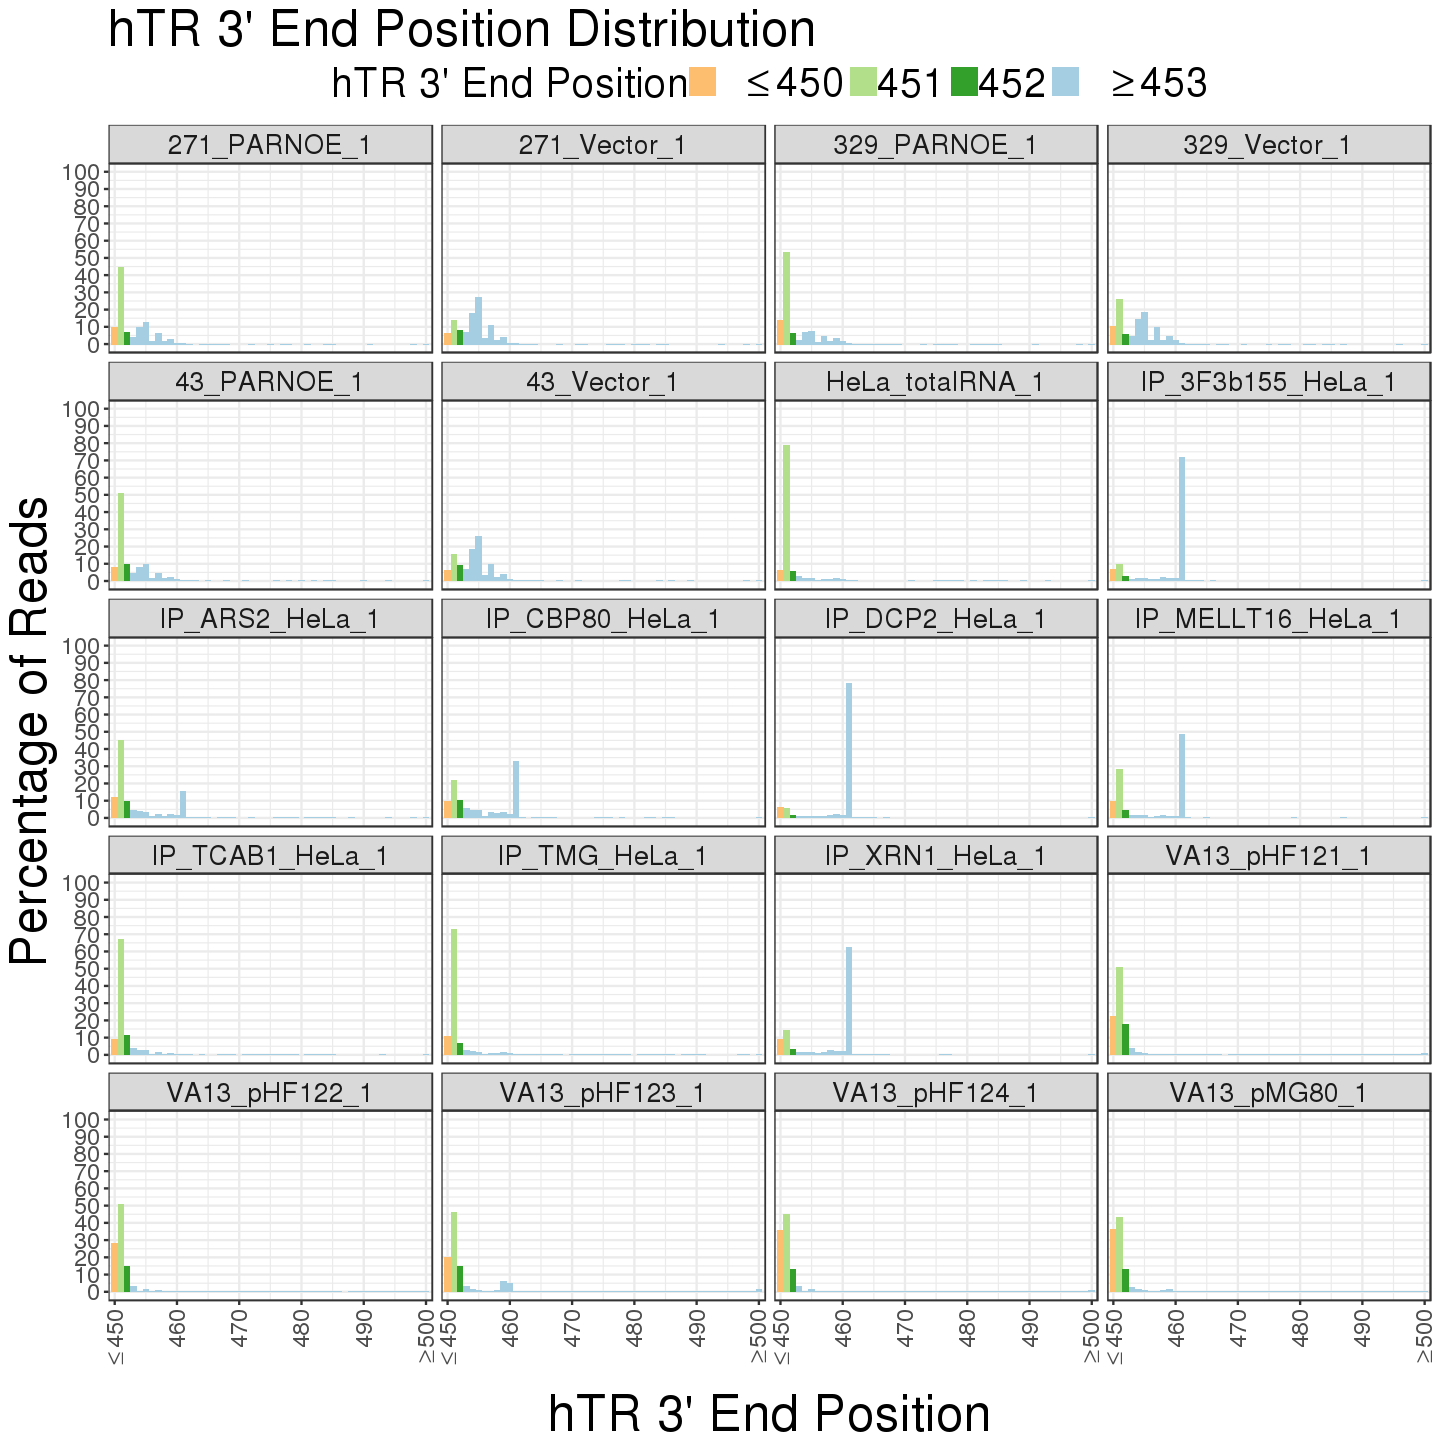

In [2]:
# set figure display dimensions
options(repr.plot.width=12, repr.plot.height=12)

# read in data
data <- read.table(file = "~/Projects/hui-fang/MOLNG-2232/processed_data/all_samples.tsv",
                   header = FALSE, 
                   sep = "\t")
# name cols
colnames(data) <- c('ntna', 'hTR_end', 'reads', 
                    'perc_reads', 'tota_reads', 'sample')

################## bin data in groups <= 450, 451, 452 & >=453 ##################
sub_450 <- subset(data, data$hTR_end <= 450.0)
sub_450$bin <- rep("<=450", nrow(sub_450))
sub_450$hTR_end <- rep(450.0, nrow(sub_450))

sub_451 <- subset(data, data$hTR_end == 451.0)
sub_451$bin <- rep("451", nrow(sub_451))
sub_452 <- subset(data, data$hTR_end == 452.0)
sub_452$bin <- rep("452", nrow(sub_452))

sub_453 <- subset(data, data$hTR_end >= 453.0 & data$hTR_end < 500.0)
sub_453$bin <- rep(">=453", nrow(sub_453))

sub_500 <- subset(data, data$hTR_end >= 500.0)
sub_500$bin <- rep(">=453", nrow(sub_500))
sub_500$hTR_end <- rep(500.0, nrow(sub_500))

bin_data <- rbind(sub_450, sub_451, sub_452, sub_453, sub_500)
#####################################################################################

# plot dataframe
g <- ggplot(bin_data, 
            aes(x = hTR_end, 
                y = perc_reads, 
                fill = as.factor(bin))) + 
            geom_bar(stat = 'identity') +
            theme_bw() +
            scale_y_continuous(expand = waiver(), 
                               limits = c(0, 100), 
                               breaks = seq(0,100,10)) +
            scale_x_continuous(expand = c(0,0), 
                               limits = c(449,501), 
                               breaks = seq(450, 500, 10), 
                               labels = c(expression(phantom(x)<= 450), 
                                          "460", "470", "480", "490", 
                                          expression(phantom(x)>= 500))) +
            ggtitle("hTR 3' End Position Distribution") +
            xlab("hTR 3' End Position") + ylab("Percentage of Reads") +
            theme(plot.title   = element_text(size=30),
                  axis.text.x  = element_text(size=14, 
                                              angle = 90, 
                                              vjust = 0.5, 
                                              hjust = 1),
                  axis.text.y  = element_text(size=14),
                  axis.title.x = element_text(size=30),
                  axis.title.y = element_text(size=30),
                  strip.text   = element_text(size=16),
                  legend.text  = element_text(size=24),
                  legend.title = element_text(size=24),
                   legend.key  = element_blank(),
                 legend.position='top') +
            scale_fill_manual(name="hTR 3' End Position",
                            values=c("<=450" = "#FDBF6F", 
                                     "451"   = "#B2DF8A",
                                     "452"   = "#33A02C", 
                                     ">=453" = "#A6CEE3"),
                            labels=c(expression(phantom(x)<= 450),  
                                     "451", "452", 
                                     expression(phantom(x)>= 453)),
                             breaks=c("<=450", "451", "452", ">=453")) +
            facet_wrap(~sample, ncol = 4)

# save figure
#ggsave(g, 
#       file="./fig/all_samples_facet_hTR_end_dist.pdf",
#       width = 12, height = 12)

g

>**In the figure above, we compare the hTR ending position in knock out samples to the control. The mature form of hTR ends at position 451, and this dominant population of hTR in the control sample. If there is an increase in the precursor population of hTR (>= 453) or premature form (<= 450) we can determine where in the RNA processing and degradation mechanism these knock out samples fit in.** 

## Binning hTR ends into categories

In [53]:
def bin_hTR_forms(samp, min_bin, max_bin, out_type):
    """ this function takes the output files in the ntna_dict_BCFILER.
    It bins this data into categories with user supplied min & max bin. 
    User defines out_type to decide if normalized percent reads (out_type='perc reads')
    or read count (out_type='num reads') are to be used."""
    
    bins = Counter()
    
    with open(samp, 'r') as fh:
      
        for line in fh:
            line = line.strip('\n')
            ntna = line.split("\t")[0]
            #print(type(line.split("\t")[1]))
            hTR_end = int(float(line.split("\t")[1]))
            reads = int(float(line.split("\t")[2]))
            perc = float(line.split("\t")[3])
            total_reads = line.split("\t")[4]
            
            if out_type == 'perc reads':
                out_count = perc
            elif out_type == 'num reads':
                out_count = reads
        
        
            if hTR_end <= min_bin: 
                if len(ntna) == 0:
                    bins['<='+str(min_bin)] += out_count
                else:
                    if ntna == 'A':
                        bins['<='+str(min_bin)+'_A'] += out_count
                    elif ntna == 'T':
                        key = '<='+str(min_bin)+'_T'
                        bins[key] += out_count
                    elif ntna == 'C':
                        key = '<='+str(min_bin)+'_C'
                        bins[key] += out_count
                    elif ntna == 'G':
                        key = '<='+str(min_bin)+'_G'
                        bins[key] += out_count
                    else:
                        non_A = sum(y != 'A' for y in ntna)
                        if non_A/float(len(ntna)) <= 0.1:
                            bins['<='+str(min_bin)+'_An'] += out_count
                        else:
                            bins['<='+str(min_bin)+'_other'] += out_count

            elif hTR_end in range(min_bin+1, max_bin):
                for i in range(min_bin+1, max_bin):
                    if hTR_end == i:
                        if len(ntna) == 0:
                            bins[str(i)] += out_count
                        else:
                            if ntna == 'A':
                                key = str(i)+'_A'
                                bins[key] += out_count
                            elif ntna == 'T':
                                key = str(i)+'_T'
                                bins[key] += out_count
                            elif ntna == 'C':
                                key = str(i)+'_C'
                                bins[key] += out_count
                            elif ntna == 'G':
                                key = str(i)+'_G'
                                bins[key] += out_count
                            
                            else:
                                non_A = sum(y != 'A' for y in ntna)
                                if non_A/float(len(ntna)) <= 0.1:
                                    key = str(i)+'_An'
                                    bins[key] += out_count
                                else:
                                    key = str(i)+'_other'
                                    bins[key] += out_count
            elif hTR_end >= max_bin: 
                if len(ntna) == 0:
                    bins['>='+str(max_bin)] += out_count
                else:
                    if ntna == 'A':
                        bins['>='+str(max_bin)+'_A'] += out_count
                    elif ntna == 'T':
                        key = '>='+str(max_bin)+'_T'
                        bins[key] += out_count
                    elif ntna == 'C':
                        key = '>='+str(max_bin)+'_C'
                        bins[key] += out_count
                    elif ntna == 'G':
                        key = '>='+str(max_bin)+'_G'
                        bins[key] += out_count
                    else:
                        non_A = sum(y != 'A' for y in ntna)
                        if non_A/float(len(ntna)) <= 0.1:
                            bins['>='+str(max_bin)+'_An'] += out_count
                        else:
                            bins['>='+str(max_bin)+'_other'] += out_count


    
    return bins

### bin into <= 386, 387, ... , 451, ..., 460, >=461

> <= 386, <=386+An, <= 386 + other

> ...

> 451, 451 + An, 451 + other

> ...

> 458, 458 + An, 458 + other

> 459, 459 + An, 459 + other

> \>= 460, >= 460 + An, >= 460 + other

    &
- hTRend_ + T
- hTRend_ + C
- hTRend_ + G

In [56]:
%%bash

mkdir -p /home/msr/code_examples/hTR_3prime_RACE_analysis_files/spreadsheets

In [19]:
# test one file
bin_hTR_forms("/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/HeLa_totalRNA_1.tsv",
             min_bin=386, max_bin=461, out_type = 'perc reads')

Counter({'387': 0.113557831759,
         '387_A': 0.000162225473942,
         '387_G': 0.00178448021336,
         '387_other': 0.10155314668754595,
         '388': 0.0178448021336,
         '388_other': 0.009571302962562001,
         '389': 0.00356896042672,
         '389_T': 0.00129780379153,
         '389_other': 0.2297112711020062,
         '390': 0.00551566611402,
         '391': 0.0629434838894,
         '391_A': 0.0233604682476,
         '391_G': 0.00129780379153,
         '391_other': 0.001622254739418,
         '392': 0.252098386505,
         '392_A': 0.00340673495278,
         '392_other': 0.000648901895767,
         '393': 0.227277888992,
         '393_A': 0.00908462654074,
         '393_An': 0.00178448021336,
         '393_T': 0.00243338210913,
         '393_other': 0.007137920853437001,
         '394': 0.0339051240538,
         '394_An': 0.000486676421825,
         '394_other': 0.000162225473942,
         '395': 0.0266049777264,
         '395_A': 0.00989575391045,
         

In [54]:

# test on file
bin_hTR_forms("/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/HeLa_totalRNA_25seqs_1_1.tsv",
             min_bin=386, max_bin=461, out_type = 'perc reads')

Counter({'451': 88.8888888889, '452': 5.55555555556, '453_An': 5.55555555556})

In [55]:
df = pd.DataFrame()

path = "/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/"
for sample in glob.glob(path+"*_1.tsv"):
    test = bin_hTR_forms(sample, min_bin=386, max_bin=461, out_type = 'perc reads')
    sample = (re.split(r'[.]', sample)[0]).split("/")[-1]
    #print sample
    temp_df = pd.DataFrame(test, columns=test.keys(), index = [sample])
    df = df.append(temp_df)
    
    
#df = df.transpose()
#df = df.sort()
df

450        451       452  452_An    453_An   455  \
HeLa_totalRNA_25seqs_1_1   NaN  88.888889  5.555556     NaN  5.555556   NaN   
329_PARNOE_25seqs_1_1     6.25  62.500000       NaN    12.5       NaN  6.25   

                          455_A  455_other  
HeLa_totalRNA_25seqs_1_1    NaN        NaN  
329_PARNOE_25seqs_1_1      6.25       6.25

In [57]:
# save as excel file 
writer = pd.ExcelWriter('/home/msr/code_examples/hTR_3prime_RACE_analysis_files/spreadsheets/testcase_hTR_3prime_end_summary.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

In [58]:
# same for number of reads 
df = pd.DataFrame()

path = "/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/"
for sample in glob.glob(path+"*_1.tsv"):
    test = bin_hTR_forms(sample, min_bin=386, max_bin=461, out_type = 'num reads')
    sample = (re.split(r'[.]', sample)[0]).split("/")[-1]
    #print sample
    temp_df = pd.DataFrame(test, columns=test.keys(), index = [sample])
    df = df.append(temp_df)
    
    
#df = df.transpose()
#df = df.sort()
df

450  451  452  452_An  453_An  455  455_A  455_other
HeLa_totalRNA_25seqs_1_1  NaN   16  1.0     NaN     1.0  NaN    NaN        NaN
329_PARNOE_25seqs_1_1     1.0   10  NaN     2.0     NaN  1.0    1.0        1.0

In [59]:
writer = pd.ExcelWriter('/home/msr/code_examples/hTR_3prime_RACE_analysis_files/spreadsheets/testcase_number_read_counts_hTR_3prime_end_summary.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

### bin into <= 442, 443, ... , 451, ..., 499, >=500

> <= 442, <=442+An, <= 442 + other

> 443, 443 + An, 443 + other

> ...

> 451, 451 + An, 451 + other

> ...

> 458, 458 + An, 458 + other

> 459, 459 + An, 459 + other

> ...
> \>= 500, >= 500 + An, >= 500 + other

    & 
- hTRend_ + T
- hTRend_ + C
- hTRend_ + G

In [60]:
%%bash

mkdir -p /home/msr/code_examples/hTR_3prime_RACE_analysis_files/spreadsheets_leq442gt500_polyA

In [22]:
# test one file
bin_hTR_forms("/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/HeLa_totalRNA_1.tsv",
             min_bin=442, max_bin=500, out_type = 'perc reads')

Counter({'443': 0.00519121516614,
         '443_other': 0.000324450947884,
         '444': 0.00421786232248,
         '444_An': 0.000648901895767,
         '444_other': 0.0048667642182469995,
         '445': 0.0133024888632,
         '445_T': 0.00113557831759,
         '445_other': 0.0019467056872999999,
         '446': 0.0295250362574,
         '446_A': 0.0113557831759,
         '446_An': 0.026118301304659003,
         '446_G': 0.0019467056873,
         '446_other': 0.009571302962558002,
         '447': 0.0403941430115,
         '447_G': 0.000162225473942,
         '447_T': 0.00210893116124,
         '447_other': 0.003244509478835,
         '448': 0.138216103798,
         '448_A': 0.0337428985799,
         '448_An': 0.068945826425209,
         '448_C': 0.000324450947883,
         '448_other': 0.012653586967457999,
         '449': 0.703085204063,
         '449_A': 0.0712169830604,
         '449_An': 0.041367495855173,
         '449_C': 0.000324450947883,
         '449_T': 0.00502898969

In [61]:
df = pd.DataFrame()

path = "/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/"
for sample in glob.glob(path+"*_1.tsv"):
    test = bin_hTR_forms(sample, min_bin=442, max_bin=500, out_type = 'perc reads')
    sample = (re.split(r'[.]', sample)[0]).split("/")[-1]
    #print sample
    temp_df = pd.DataFrame(test, columns=test.keys(), index = [sample])
    df = df.append(temp_df)
    
    
#df = df.transpose()
#df = df.sort()
df

450        451       452  452_An    453_An   455  \
HeLa_totalRNA_25seqs_1_1   NaN  88.888889  5.555556     NaN  5.555556   NaN   
329_PARNOE_25seqs_1_1     6.25  62.500000       NaN    12.5       NaN  6.25   

                          455_A  455_other  
HeLa_totalRNA_25seqs_1_1    NaN        NaN  
329_PARNOE_25seqs_1_1      6.25       6.25

In [62]:
# save as excel sheet
writer = pd.ExcelWriter('/home/msr/code_examples/hTR_3prime_RACE_analysis_files/spreadsheets_leq442gt500_polyA/testcase_hTR_3prime_end_polyA_summary.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

In [63]:
# same for number of reads

df = pd.DataFrame()

path = "/home/msr/code_examples/hTR_3prime_RACE_analysis_files/processed_data/ntna_dict_BCFILTER/"
for sample in glob.glob(path+"*_1.tsv"):
    test = bin_hTR_forms(sample, min_bin=442, max_bin=500, out_type = 'num reads')
    sample = (re.split(r'[.]', sample)[0]).split("/")[-1]
    #print sample
    temp_df = pd.DataFrame(test, columns=test.keys(), index = [sample])
    df = df.append(temp_df)
    
    
#df = df.transpose()
#df = df.sort()

df

450  451  452  452_An  453_An  455  455_A  455_other
HeLa_totalRNA_25seqs_1_1  NaN   16  1.0     NaN     1.0  NaN    NaN        NaN
329_PARNOE_25seqs_1_1     1.0   10  NaN     2.0     NaN  1.0    1.0        1.0

In [64]:
# save num reads as excel file
writer = pd.ExcelWriter('/home/msr/code_examples/hTR_3prime_RACE_analysis_files/spreadsheets_leq442gt500_polyA/testcase_read_counts_hTR_3prime_end_polyA_summary.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

## Identify & Plot distribution of polyA tails

### Identify polyA tails

In [ ]:
%%bash
# prepare output directories
mkdir -p ./spreadsheets/A_dist_df_10percNonA/
mkdir -p ./A_dist_df_10percNonA/
mkdir -p ./fig/A_dist_df_10percNonA

In [31]:
def get_A_dist(samp, define):
    """ this function takes the ntna tsv file per sample and a threshold 
    for defining what is concidered a polyA tail. It returns a dictionary where 
    the key is a tuple of:
        (polyA ntna sequene, lenght of the polyA sequence, corresponding hTR ending position)
    and the value is the number of times this key is found in the sample.
    
    The two polyA definitions to choose from are:
        (1) pure polyA (no other nt present)
        (2) polyA sequence allowing 10% non-As (to accound for sequencing error or a
    sloppy poly-A polymerase adding non-As). This threshold can easily be changed to allow 
    any percent deviation from pure polyA. This threshold only takes effect when the polyA sequence
    is at least 10nt. So an ntna sequence with 9 As and 1 non-A will get counted.
    """
    # key = (polyA ntna seq, len, end pos), val = reads
    dist_A_dict = Counter() # initialize counter dict

    sample = re.split('_1', re.split(r'[/]', samp)[-1])[0] # grab the sample name 
    
    with open(samp, 'r') as fh:

        not_A = ['C','G','T'] # this is for computing the pure A

        for line in fh:
            # extract info from file
            ntna = line.split("\t")[0] # grab ntna seq
            end_pos = int(float(line.split("\t")[1])) # grab hTR ending coordinate
            reads = int(line.split("\t")[2]) # grab number reads
            total_reads = int(line.split("\t")[4]) # grab total reads

            # bin the hTR ending coordinates into <= 450 and >=454
            if end_pos <= 450.0:
                end_pos = '<=450'
            elif end_pos >= 454.0:
                end_pos = '>=454'
                
            if len(ntna) != 0: # if an ntna sequence exists
                if define == 'pure': # threshold (1) all A's in ntna seq
                    pure_A = map(lambda x: x in ntna, not_A) # checks ntna sequence if all As, if so returns True
                    if True in pure_A: # if there is a pure polyA sequence then add it do the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_A_dict[key] += reads
                elif define == 'allow_10%_non': # threshold (2) allow 10% non-A in ntna seq
                    non_A = sum(y != 'A' for y in ntna) # count how many times a non-A seq is found in the ntna
                    if float(non_A)/float(len(ntna)) <= 0.1: # non-A seq divided by the total length of the seq 
                                                             # give the fraction of non-A's in ntna
                                                             # if this fraction is <= 0.1 then add the seq to the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_A_dict[key] += reads
            elif len(ntna) == 0 and end_pos == 452:
                dist_A_dict[('A', 1, '451', total_reads, sample)] += reads
            
    return dist_A_dict

In [36]:
def make_A_dist_df(A_dist_dict):
    """ this function converts your A_dist_dict into a dataframe for saving"""
    
    df = pd.DataFrame(columns=('len_A', 'hTR_end', 'perc_reads', 'sample')) # initialize dataframe
   
    for key, val in A_dist_dict.items(): # loop through dict
            h = [key[1], key[2], (float(val)/float(key[3]))*100, key[4]] # keep length of polyA seq, hTR ending coordinate
                                                                 # and compute normalized percent of reads
            # add to dataframe
            df = df.append(pd.Series(h, index = ['len_A', 'hTR_end', 'perc_reads', 'sample']), 
                           ignore_index=True)
    
    return df

In [ ]:
path = "./ntna_dict_BCFILTER/"
df_summary = pd.DataFrame(columns=('len_T', 'hTR_end', 'perc_reads', 'sample')) # initialize summary dataframe

for sample in os.listdir(path): # for each sample
    A_dist = get_A_dist(path + sample, 'allow_10%_non') # call the get_A_dist function with polyA threshold allowing 10% nonA
    df_A = make_A_dist_df(A_dist) # conver get_A_dist dict to dataframe
    sample = re.split('_1', re.split(r'[.]', sample)[0])[0] # grab the sample name
    out_file = "./processed_data/A_dist_df_10percNonA/" + sample + ".csv" # outfile named by sample
    df_A.to_csv(out_file, index = False) # save dataframe as csv
    
    # save as excel spreadsheet, each sample will be a differnt tab
    writer = pd.ExcelWriter('./spreadsheets/A_dist_df_10percNonA/' + sample + '.xlsx')
    df_A.to_excel(writer, sample)
    writer.save()
    
    df_summary = df_summary.append(df_A)

df_summary

out_file = "./processed_data/A_dist_df_10percNonA/sample_summary_Adist.csv" # outfile
df_summary.to_csv(out_file, index = False) # save dataframe as csv

# save as excel spreadsheet, each sample will be a differnt tab
writer = pd.ExcelWriter('./spreadsheets/A_dist_df_10percNonA/sample_summary_Adist.xlsx')
df_summary.to_excel(writer)
writer.save()

In [38]:
############## testing get_A_dist function #################

path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/"
sample = "HeLa_totalRNA_1.tsv"
A_dist = get_A_dist(path + sample, 'allow_10%_non')
A_dist
#make_A_dist_df(A_dist)

Counter({('A', 1, '451', 616426, 'HeLa_totalRNA'): 16802,
         ('A', 1, '452', 616426, 'HeLa_totalRNA'): 5511,
         ('A', 1, '453', 616426, 'HeLa_totalRNA'): 555,
         ('A', 1, '<=450', 616426, 'HeLa_totalRNA'): 3020,
         ('A', 1, '>=454', 616426, 'HeLa_totalRNA'): 7394,
         ('AA', 2, '452', 616426, 'HeLa_totalRNA'): 2521,
         ('AA', 2, '453', 616426, 'HeLa_totalRNA'): 1335,
         ('AA', 2, '<=450', 616426, 'HeLa_totalRNA'): 744,
         ('AA', 2, '>=454', 616426, 'HeLa_totalRNA'): 3766,
         ('AAA', 3, '452', 616426, 'HeLa_totalRNA'): 2226,
         ('AAA', 3, '453', 616426, 'HeLa_totalRNA'): 1413,
         ('AAA', 3, '<=450', 616426, 'HeLa_totalRNA'): 491,
         ('AAA', 3, '>=454', 616426, 'HeLa_totalRNA'): 3462,
         ('AAAA', 4, '452', 616426, 'HeLa_totalRNA'): 2042,
         ('AAAA', 4, '453', 616426, 'HeLa_totalRNA'): 1901,
         ('AAAA', 4, '<=450', 616426, 'HeLa_totalRNA'): 163,
         ('AAAA', 4, '>=454', 616426, 'HeLa_totalRNA'): 

### Plot polyA tail distribution

In [ ]:
%%bash
# concatonate each Adist per sample into one file
for i in ./A_dist_df_10percNonA/*.csv; do cat $i | grep -v "len_A" | sed "s/$/,$(basename $i .csv)/" >> ./A_dist_df_10percNonA/all_samples.csv; done

In [1]:
## start R kernel
library(ggplot2)
library(RColorBrewer)

In [4]:
# set figure display dimensions
options(repr.plot.width=12, repr.plot.height=12)

# read in data
data <- read.table(file = "~/Projects/hui-fang/MOLNG-2232/processed_data/A_dist_df_10percNonA/all_samples.csv",
                   header = FALSE, 
                   sep = ",")
# name cols
colnames(data) <- c('len_A', 'hTR_end', 'perc_reads', 'sample')

###################### bin data in groups <= 450, 451, 452, 453 & >=454 ######################
data_450 <- subset(data, data$hTR_end == "<=450")
data_451 <- subset(data, hTR_end == "451")
data_452 <- subset(data, hTR_end == "452")
data_453 <- subset(data, data$hTR_end == "453")
data_454 <- subset(data, data$hTR_end == ">=454")
data_bins <- rbind(data_450, data_451, data_452, data_453, data_454)
data_bins$hTR_end <- factor(data_bins$hTR_end, 
                            levels = rev(c("<=450", '451', '452', '453', ">=454")))
################################################################################################

# plot dataframe
g <- ggplot(data_bins, 
            aes(x    = len_A, 
                y    = perc_reads, 
                fill = hTR_end)) + 

        geom_bar(width    = 1, 
                 stat     = 'identity', 
                 alpha    = 1, 
                 position = 'stack') +
        
        scale_y_continuous(limits = c(0, max(data_bins$perc_reads)+5), 
                           breaks = seq(0, max(data_bins$perc_reads), 5))+
        scale_x_continuous(limits = c(0,max(data_bins$len_A)), 
                           breaks = seq(0, max(data_bins$len_A), 5))+

        ggtitle("Distribution of polyA lengths (allowing 10% non-A)")+
        xlab("Length of polyA") + ylab("Percentage of Reads") +
        scale_fill_manual(name = "hTR End Position",
                          values = rev(c("darkorange2", "#74c476", 
                                         "DarkGreen", "#7BCCC4", "#1F78B4")))+
        theme_bw()+
        theme(plot.title   = element_text(size = 20),
              axis.text.x  = element_text(size = 20, 
                                          angle = 90, 
                                          vjust = 0.5),
              axis.text.y  = element_text(size = 20),
              axis.title.x = element_text(size = 20),
              axis.title.y = element_text(size = 20),
              strip.text   = element_text(size = 16),
              legend.text  = element_text(size = 20),
              legend.title = element_text(size = 20),
              legend.key   = element_blank(),
              legend.position = 'top') +
            facet_wrap(~sample, ncol = 4)

# save fig
#ggsave(file="./fig/A_dist_df_10percNonA/all_samples_polyA_len_stack.pdf", 
#       g, width = 14, height = 14)
g

## PolyT distribution

In [ ]:
%%bash
# prepare output directories
mkdir -p ./spreadsheets/T_dist_df_10percNonT/
mkdir -p ./processed_data/T_dist_df_10percNonT/

In [25]:
def get_T_dist(samp, define):
    """ this function takes the ntna tsv file per sample and a threshold 
    for defining what is concidered a polyT tail. It returns a dictionary where 
    the key is a tuple of:
        (polyT ntna sequene, lenght of the polyT sequence, corresponding hTR ending position)
    and the value is the number of times this key is found in the sample.
    
    The two polyT definitions to choose from are:
        (1) pure polyT (no other nt present)
        (2) polyT sequence allowing 10% non-Ts This threshold can easily be changed to allow 
    any percent deviation from pure polyT. 
    """
    sample = re.split('_1', re.split(r'[/]', samp)[-1])[0] # grab the sample name 
    
    # key = (poly ntna seq, len, end pos), val = reads
    dist_T_dict = Counter() # initialize counter dict

    with open(samp, 'r') as fh:

        not_T = ['C','G','A'] # this is for computing the pure T

        for line in fh:
            # extract info from file
            ntna = line.split("\t")[0] # grab ntna seq
            end_pos = int(float(line.split("\t")[1])) # grab hTR ending coordinate
            reads = int(line.split("\t")[2]) # grab number reads
            total_reads = int(line.split("\t")[4]) # grab total reads

            # bin the hTR ending coordinates into <= 450 and >=454
            if end_pos <= 450.0:
                end_pos = '<=450'
            elif end_pos >= 454.0:
                end_pos = '>=454'
                
            if len(ntna) != 0: # if an ntna sequence exists
                if define == 'pure': # threshold (1) all T's in ntna seq
                    pure = map(lambda x: x in ntna, not_T) # checks ntna sequence if all Ts, if so returns True
                    if True in pure: # if there is a pure polyT sequence then add it do the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_T_dict[key] += reads
                elif define == 'allow_10%_non': # threshold (2) allow 10% non-T in ntna seq
                    non_T = sum(y != 'T' for y in ntna) # count how many times a non-T seq is found in the ntna
                    if float(non_T)/float(len(ntna)) <= 0.1: # non-T seq divided by the total length of the seq 
                                                             # give the fraction of non-T's in ntna
                                                             # if this fraction is <= 0.1 then add the seq to the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_T_dict[key] += reads
    return dist_T_dict

In [27]:
def make_T_dist_df(T_dist_dict):
    """ this function converts your _dist_dict into a dataframe for saving"""
    
    df = pd.DataFrame(columns=('len_T', 'hTR_end', 'perc_reads', 'sample')) # initialize dataframe
   
    for key, val in T_dist_dict.items(): # loop through dict
            h = [key[1], key[2], (float(val)/float(key[3]))*100, key[4]] # keep length of poly seq, hTR ending coordinate
                                                                 # and compute normalized percent of reads
            # add to dataframe
            df = df.append(pd.Series(h, index = ['len_T', 'hTR_end', 'perc_reads', 'sample']), 
                           ignore_index=True)
    
    return df

In [29]:
path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/"
df_summary = pd.DataFrame(columns=('len_T', 'hTR_end', 'perc_reads', 'sample')) # initialize dataframe

for sample in os.listdir(path): # for each sample
    T_dist = get_T_dist(path + sample, 'allow_10%_non') # call the get_T_dist function with polyT threshold allowing 10% nonT
    df_T = make_T_dist_df(T_dist) # convert get_T_dist dict to dataframe
    df_summary = df_summary.append(df_T)
df_summary

out_file = "./processed_data/T_dist_df_10percNonT/sample_summary_Tdist.csv" # outfile
df_summary.to_csv(out_file, index = False) # save dataframe as csv

# save as excel spreadsheet, each sample will be a differnt tab
writer = pd.ExcelWriter('./spreadsheets/T_dist_df_10percNonT/sample_summary_Tdist.xlsx')
df_summary.to_excel(writer)
writer.save()

len_T hTR_end  perc_reads         sample
0      2     451    0.003393   IP_ARS2_HeLa
1      4   >=454    0.028616   IP_ARS2_HeLa
2      7   >=454    0.001536   IP_ARS2_HeLa
3     12   <=450    0.000256   IP_ARS2_HeLa
4      8   >=454    0.000128   IP_ARS2_HeLa
5      3   <=450    0.006978   IP_ARS2_HeLa
6     23   <=450    0.000064   IP_ARS2_HeLa
7      6   >=454    0.002241   IP_ARS2_HeLa
8     21   <=450    0.000128   IP_ARS2_HeLa
9      2   <=450    0.040331   IP_ARS2_HeLa
10    11   <=450    0.002433   IP_ARS2_HeLa
11    22   <=450    0.000064   IP_ARS2_HeLa
12     2   >=454    0.061648   IP_ARS2_HeLa
13    13   <=450    0.000576   IP_ARS2_HeLa
14    15   <=450    0.000320   IP_ARS2_HeLa
15     1   >=454    0.116959   IP_ARS2_HeLa
16     1     451    0.061328   IP_ARS2_HeLa
17     3     451    0.004737   IP_ARS2_HeLa
18    14   <=450    0.000256   IP_ARS2_HeLa
19    16   >=454    0.000128   IP_ARS2_HeLa
20     9   <=450    0.000896   IP_ARS2_HeLa
21     5   <=450    0.004673   IP_ARS2_HeLa
22    14   <=450    0.000128   IP_ARS2_HeLa
23     5   >=454    0.005121   IP_ARS2_HeLa
24    17   >=454    0.000064   IP_ARS2_HeLa
25     1   <=450    0.316629   IP_ARS2_HeLa
26     8   <=450    0.000064   IP_ARS2_HeLa
27    23   <=450    0.000064   IP_ARS2_HeLa
28    13   <=450    0.000512   IP_ARS2_HeLa
29    10   <=450    0.000896   IP_ARS2_HeLa
..   ...     ...         ...            ...
23     3   >=454    0.004202     329_PARNOE
24     1     452    0.004071     329_PARNOE
25     9   <=450    0.002232     329_PARNOE
0      1   <=450    0.211932  IP_TCAB1_HeLa
1      4   <=450    0.002210  IP_TCAB1_HeLa
2      3   <=450    0.006017  IP_TCAB1_HeLa
3     12   >=454    0.000123  IP_TCAB1_HeLa
4      2   <=450    0.020260  IP_TCAB1_HeLa
5      5   <=450    0.000123  IP_TCAB1_HeLa
6     14   <=450    0.000123  IP_TCAB1_HeLa
7     19   >=454    0.000123  IP_TCAB1_HeLa
8      4   >=454    0.002087  IP_TCAB1_HeLa
9     11   <=450    0.000123  IP_TCAB1_HeLa
10     2     452    0.000491  IP_TCAB1_HeLa
11     9   >=454    0.000368  IP_TCAB1_HeLa
12     6   >=454    0.000123  IP_TCAB1_HeLa
13    10     451    0.000368  IP_TCAB1_HeLa
14     1   >=454    0.030574  IP_TCAB1_HeLa
15    14   >=454    0.000123  IP_TCAB1_HeLa
16     2     451    0.002947  IP_TCAB1_HeLa
17     3     451    0.001473  IP_TCAB1_HeLa
18     2   >=454    0.002824  IP_TCAB1_HeLa
19     1     451    0.040152  IP_TCAB1_HeLa
20    12   <=450    0.000123  IP_TCAB1_HeLa
21     7   <=450    0.000737  IP_TCAB1_HeLa
22     6   <=450    0.000246  IP_TCAB1_HeLa
23     3   >=454    0.001473  IP_TCAB1_HeLa
24     1     452    0.004666  IP_TCAB1_HeLa
25     7   >=454    0.000368  IP_TCAB1_HeLa
26     5   >=454    0.000614  IP_TCAB1_HeLa

[731 rows x 4 columns]

In [30]:
############## testing get_T_dist function #################

path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/"
sample = "HeLa_totalRNA_1.tsv"
T_dist = get_T_dist(path + sample, 'allow_10%_non')
print T_dist
df_T = make_T_dist_df(T_dist) # convert get_T_dist dict to dataframe
df_T

Counter({('T', 1, '<=450', 616426, 'HeLa_totalRNA'): 2394, ('T', 1, '451', 616426, 'HeLa_totalRNA'): 120, ('TT', 2, '<=450', 616426, 'HeLa_totalRNA'): 108, ('T', 1, '>=454', 616426, 'HeLa_totalRNA'): 70, ('TTT', 3, '<=450', 616426, 'HeLa_totalRNA'): 31, ('T', 1, '452', 616426, 'HeLa_totalRNA'): 18, ('TT', 2, '451', 616426, 'HeLa_totalRNA'): 14, ('TTT', 3, '>=454', 616426, 'HeLa_totalRNA'): 6, ('TTTT', 4, '<=450', 616426, 'HeLa_totalRNA'): 5, ('TTTT', 4, '>=454', 616426, 'HeLa_totalRNA'): 3, ('TTTTTTTTTTT', 11, '>=454', 616426, 'HeLa_totalRNA'): 2, ('TTTTTTTATT', 10, '<=450', 616426, 'HeLa_totalRNA'): 2, ('TTTTTTTTTTTT', 12, '>=454', 616426, 'HeLa_totalRNA'): 1, ('TT', 2, '>=454', 616426, 'HeLa_totalRNA'): 1, ('TTTTTTTTTT', 10, '>=454', 616426, 'HeLa_totalRNA'): 1, ('TTTTTTTTTTTTTTTTTAT', 19, '<=450', 616426, 'HeLa_totalRNA'): 1, ('TTTTTTTTTTTTT', 13, '>=454', 616426, 'HeLa_totalRNA'): 1})


len_T hTR_end  perc_reads         sample
0      3   >=454    0.000973  HeLa_totalRNA
1     12   >=454    0.000162  HeLa_totalRNA
2      2   >=454    0.000162  HeLa_totalRNA
3     11   >=454    0.000324  HeLa_totalRNA
4     10   >=454    0.000162  HeLa_totalRNA
5     19   <=450    0.000162  HeLa_totalRNA
6     13   >=454    0.000162  HeLa_totalRNA
7      4   >=454    0.000487  HeLa_totalRNA
8     10   <=450    0.000324  HeLa_totalRNA
9      1     451    0.019467  HeLa_totalRNA
10     1   >=454    0.011356  HeLa_totalRNA
11     2   <=450    0.017520  HeLa_totalRNA
12     4   <=450    0.000811  HeLa_totalRNA
13     1   <=450    0.388368  HeLa_totalRNA
14     1     452    0.002920  HeLa_totalRNA
15     2     451    0.002271  HeLa_totalRNA
16     3   <=450    0.005029  HeLa_totalRNA

## PolyG distribution

In [ ]:
%%bash
# prepare output directories
mkdir -p ./spreadsheets/G_dist_df_10percNonG/
mkdir -p ./processed_data/G_dist_df_10percNonG/

In [39]:
def get_G_dist(samp, define):
    """ this function takes the ntna tsv file per sample and a threshold 
    for defining what is concidered a poly tail. It returns a dictionary where 
    the key is a tuple of:
        (polyN ntna sequene, lenght of the polyT sequence, corresponding hTR ending position)
    and the value is the number of times this key is found in the sample.
    
    The two polyN definitions to choose from are:
        (1) pure polyN (no other nt present)
        (2) polyN sequence allowing 10% non-Gs This threshold can easily be changed to allow 
    any percent deviation from pure polyG. 
    """
    sample = re.split('_1', re.split(r'[/]', samp)[-1])[0] # grab the sample name 
    
    # key = (poly ntna seq, len, end pos), val = reads
    dist_G_dict = Counter() # initialize counter dict

    with open(samp, 'r') as fh:

        not_G = ['C','T','A'] # this is for computing the pure G

        for line in fh:
            # extract info from file
            ntna = line.split("\t")[0] # grab ntna seq
            end_pos = int(float(line.split("\t")[1])) # grab hTR ending coordinate
            reads = int(line.split("\t")[2]) # grab number reads
            total_reads = int(line.split("\t")[4]) # grab total reads

            # bin the hTR ending coordinates into <= 450 and >=454
            if end_pos <= 450.0:
                end_pos = '<=450'
            elif end_pos >= 454.0:
                end_pos = '>=454'
                
            if len(ntna) != 0: # if an ntna sequence exists
                if define == 'pure': # threshold (1) all G's in ntna seq
                    pure = map(lambda x: x in ntna, not_G) # checks ntna sequence if all Gs, if so returns True
                    if True in pure: # if there is a pure polyG sequence then add it do the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_G_dict[key] += reads
                elif define == 'allow_10%_non': # threshold (2) allow 10% non-G in ntna seq
                    non_G = sum(y != 'G' for y in ntna) # count how many times a non-G seq is found in the ntna
                    if float(non_G)/float(len(ntna)) <= 0.1: # non-G seq divided by the total length of the seq 
                                                             # give the fraction of non-G's in ntna
                                                             # if this fraction is <= 0.1 then add the seq to the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_G_dict[key] += reads
    return dist_G_dict

In [40]:
def make_G_dist_df(G_dist_dict):
    """ this function converts your _dist_dict into a dataframe for saving"""
    
    df = pd.DataFrame(columns=('len_G', 'hTR_end', 'perc_reads', 'sample')) # initialize dataframe
   
    for key, val in G_dist_dict.items(): # loop through dict
            h = [key[1], key[2], (float(val)/float(key[3]))*100, key[4]] # keep length of poly seq, hTR ending coordinate
                                                                 # and compute normalized percent of reads
            # add to dataframe
            df = df.append(pd.Series(h, index = ['len_G', 'hTR_end', 'perc_reads', 'sample']), 
                           ignore_index=True)
    
    return df

In [ ]:
path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/"
df_summary = pd.DataFrame(columns=('len_G', 'hTR_end', 'perc_reads', 'sample')) # initialize dataframe

for sample in os.listdir(path): # for each sample
    G_dist = get_G_dist(path + sample, 'allow_10%_non') # call the get_G_dist function with polyG threshold allowing 10% nonG
    df_G = make_G_dist_df(G_dist) # convert get_G_dist dict to dataframe
    df_summary = df_summary.append(df_G)
df_summary

out_file = "./processed_data/G_dist_df_10percNonG/sample_summary_Gdist.csv" # outfile
df_summary.to_csv(out_file, index = False) # save dataframe as csv

# save as excel spreadsheet, each sample will be a differnt tab
writer = pd.ExcelWriter('./spreadsheets/G_dist_df_10percNonG/sample_summary_Gdist.xlsx')
df_summary.to_excel(writer)
writer.save()

In [41]:
############## testing get_T_dist function #################

path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/"
sample = "HeLa_totalRNA_1.tsv"
G_dist = get_G_dist(path + sample, 'allow_10%_non')
print G_dist
df_G = make_G_dist_df(G_dist) # convert get_G_dist dict to dataframe
df_G

Counter({('G', 1, '>=454', 616426, 'HeLa_totalRNA'): 416, ('G', 1, '<=450', 616426, 'HeLa_totalRNA'): 116, ('GG', 2, '451', 616426, 'HeLa_totalRNA'): 17, ('G', 1, '451', 616426, 'HeLa_totalRNA'): 14, ('GG', 2, '>=454', 616426, 'HeLa_totalRNA'): 7, ('GGG', 3, '451', 616426, 'HeLa_totalRNA'): 5, ('GGG', 3, '<=450', 616426, 'HeLa_totalRNA'): 1, ('G', 1, '453', 616426, 'HeLa_totalRNA'): 1})


len_G hTR_end  perc_reads         sample
0     1   <=450    0.018818  HeLa_totalRNA
1     3   <=450    0.000162  HeLa_totalRNA
2     2     451    0.002758  HeLa_totalRNA
3     3     451    0.000811  HeLa_totalRNA
4     1   >=454    0.067486  HeLa_totalRNA
5     2   >=454    0.001136  HeLa_totalRNA
6     1     453    0.000162  HeLa_totalRNA
7     1     451    0.002271  HeLa_totalRNA

## PolyC distribution

In [ ]:
%%bash
# prepare output directories
mkdir -p ./spreadsheets/C_dist_df_10percNonC/
mkdir -p ./processed_data/C_dist_df_10percNonC/

In [42]:
def get_C_dist(samp, define):
    """ this function takes the ntna tsv file per sample and a threshold 
    for defining what is concidered a poly tail. It returns a dictionary where 
    the key is a tuple of:
        (polyN ntna sequene, lenght of the polyT sequence, corresponding hTR ending position)
    and the value is the number of times this key is found in the sample.
    
    The two polyN definitions to choose from are:
        (1) pure polyN (no other nt present)
        (2) polyN sequence allowing 10% non-Cs This threshold can easily be changed to allow 
    any percent deviation from pure polyC. 
    """
    sample = re.split('_1', re.split(r'[/]', samp)[-1])[0] # grab the sample name 
    
    # key = (poly ntna seq, len, end pos), val = reads
    dist_C_dict = Counter() # initialize counter dict

    with open(samp, 'r') as fh:

        not_C = ['G','T','A'] # this is for computing the pure C

        for line in fh:
            # extract info from file
            ntna = line.split("\t")[0] # grab ntna seq
            end_pos = int(float(line.split("\t")[1])) # grab hTR ending coordinate
            reads = int(line.split("\t")[2]) # grab number reads
            total_reads = int(line.split("\t")[4]) # grab total reads

            # bin the hTR ending coordinates into <= 450 and >=454
            if end_pos <= 450.0:
                end_pos = '<=450'
            elif end_pos >= 454.0:
                end_pos = '>=454'
                
            if len(ntna) != 0: # if an ntna sequence exists
                if define == 'pure': # threshold (1) all C's in ntna seq
                    pure = map(lambda x: x in ntna, not_C) # checks ntna sequence if all Cs, if so returns True
                    if True in pure: # if there is a pure polyC sequence then add it do the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_C_dict[key] += reads
                elif define == 'allow_10%_non': # threshold (2) allow 10% non-G in ntna seq
                    non_C = sum(y != 'C' for y in ntna) # count how many times a non-G seq is found in the ntna
                    if float(non_C)/float(len(ntna)) <= 0.1: # non-C seq divided by the total length of the seq 
                                                             # give the fraction of non-C's in ntna
                                                             # if this fraction is <= 0.1 then add the seq to the dict
                        key = (ntna, len(ntna), str(end_pos), total_reads, sample)
                        dist_C_dict[key] += reads
    return dist_C_dict

In [43]:
def make_C_dist_df(C_dist_dict):
    """ this function converts your _dist_dict into a dataframe for saving"""
    
    df = pd.DataFrame(columns=('len_C', 'hTR_end', 'perc_reads', 'sample')) # initialize dataframe
   
    for key, val in C_dist_dict.items(): # loop through dict
            h = [key[1], key[2], (float(val)/float(key[3]))*100, key[4]] # keep length of poly seq, hTR ending coordinate
                                                                 # and compute normalized percent of reads
            # add to dataframe
            df = df.append(pd.Series(h, index = ['len_C', 'hTR_end', 'perc_reads', 'sample']), 
                           ignore_index=True)
    
    return df

In [ ]:
path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/"
df_summary = pd.DataFrame(columns=('len_C', 'hTR_end', 'perc_reads', 'sample')) # initialize dataframe

for sample in os.listdir(path): # for each sample
    C_dist = get_C_dist(path + sample, 'allow_10%_non') # call the get_C_dist function with polyC threshold allowing 10% nonC
    df_C = make_C_dist_df(C_dist) # convert get_C_dist dict to dataframe
    df_summary = df_summary.append(df_C)
df_summary

out_file = "./processed_data/C_dist_df_10percNonC/sample_summary_Cdist.csv" # outfile
df_summary.to_csv(out_file, index = False) # save dataframe as csv

# save as excel spreadsheet, each sample will be a differnt tab
writer = pd.ExcelWriter('./spreadsheets/C_dist_df_10percNonC/sample_summary_Cdist.xlsx')
df_summary.to_excel(writer)
writer.save()

In [44]:
############## testing get_T_dist function #################

path = "/home/msr/Projects/hui-fang/MOLNG-2232/processed_data/ntna_dict_BCFILTER/"
sample = "HeLa_totalRNA_1.tsv"
C_dist = get_C_dist(path + sample, 'allow_10%_non')
print C_dist
df_C = make_C_dist_df(C_dist) # convert get_C_dist dict to dataframe
df_C

Counter({('C', 1, '451', 616426, 'HeLa_totalRNA'): 35, ('CC', 2, '<=450', 616426, 'HeLa_totalRNA'): 20, ('C', 1, '452', 616426, 'HeLa_totalRNA'): 14, ('C', 1, '>=454', 616426, 'HeLa_totalRNA'): 6, ('CC', 2, '451', 616426, 'HeLa_totalRNA'): 5, ('C', 1, '<=450', 616426, 'HeLa_totalRNA'): 4, ('C', 1, '453', 616426, 'HeLa_totalRNA'): 2, ('CC', 2, '>=454', 616426, 'HeLa_totalRNA'): 1})


len_C hTR_end  perc_reads         sample
0     1     453    0.000324  HeLa_totalRNA
1     1   <=450    0.000649  HeLa_totalRNA
2     1     452    0.002271  HeLa_totalRNA
3     1     451    0.005678  HeLa_totalRNA
4     1   >=454    0.000973  HeLa_totalRNA
5     2   <=450    0.003245  HeLa_totalRNA
6     2   >=454    0.000162  HeLa_totalRNA
7     2     451    0.000811  HeLa_totalRNA